<a href="https://colab.research.google.com/github/falguni-rathore/PSGV-DataAnalytics/blob/main/heart_murmur_detection_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis


# Heartbeat Murmur Detection Using Phonocardiogram Recordings

**Team:8**
* Falguni Rathore
* Abhijna Vadadi


**Course:** DAAN 897– Deep Learning (Spring II, 2023)

## Problem Statement

The objective of our project is to accurately determine the presence or absence of murmurs from heart sound recordings obtained from various auscultation points on the body using a digital stethoscope. This includes identifying unclear cases of murmurs, which is an important step in providing an early diagnosis and effective treatment of heart conditions in children.

## Data Collection
* Source(url): https://moody-challenge.physionet.org/2022/
* Short Description : 
There are total 1568 patients with one of more heart sound recordings, the data also contains information about the demography of these patients like age, sex, diastolic readings etc.
There is one main column – Murmur labels - This indicated the presence or absence of a murmur in a patient from the recordings or unknown if the diagnosing physician was unsure.

* Keywords: Heartbeat murmur detection, heart diseases, ausculation, murmur classification

### Required packages

python3 and pip are necessary for installation, most other packages can be installed using pip install (package name) through terminal, command line or inbuilt command line in anaconda.



In [ ]:
#ignore warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import soundfile as sf
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet152
from torchvision import transforms, datasets
from tqdm import tqdm
from ipywidgets import FloatProgress
import time

### Importing the dataset

In [ ]:
# Load the metadata file
metadata = pd.read_csv('../input/heart-murmur-detection/heart_murmur_detection/training_data.csv')
metadata.head()

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


### Exploring a sample audio file

In [ ]:
#Example Audi0
audio, sample_rate = librosa.load('../input/heart-murmur-detection/heart_murmur_detection/training_data/9979_MV.wav')

# Play the audio file
ipd.Audio(audio,rate=sample_rate)

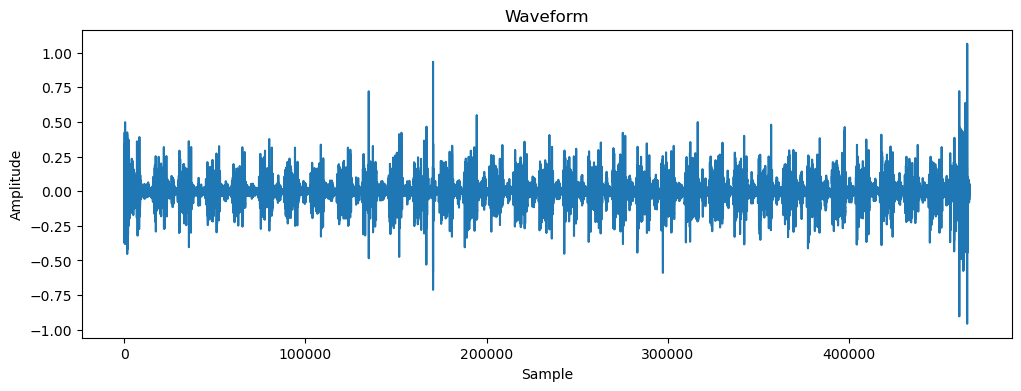

In [ ]:
# Plot waveform from audio
plt.figure(figsize=(12, 4))
plt.plot(audio)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
#Checking the Shape of the data
metadata.shape

(942, 23)

In [ ]:
#Checking for info
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient ID                942 non-null    int64  
 1   Recording locations:      942 non-null    object 
 2   Age                       868 non-null    object 
 3   Sex                       942 non-null    object 
 4   Height                    826 non-null    float64
 5   Weight                    837 non-null    float64
 6   Pregnancy status          942 non-null    bool   
 7   Murmur                    942 non-null    object 
 8   Murmur locations          179 non-null    object 
 9   Most audible location     179 non-null    object 
 10  Systolic murmur timing    178 non-null    object 
 11  Systolic murmur shape     178 non-null    object 
 12  Systolic murmur grading   178 non-null    object 
 13  Systolic murmur pitch     178 non-null    object 
 14  Systolic m

In [ ]:
#Checking for null values
metadata.isna().sum()

Patient ID                    0
Recording locations:          0
Age                          74
Sex                           0
Height                      116
Weight                      105
Pregnancy status              0
Murmur                        0
Murmur locations            763
Most audible location       763
Systolic murmur timing      764
Systolic murmur shape       764
Systolic murmur grading     764
Systolic murmur pitch       764
Systolic murmur quality     764
Diastolic murmur timing     937
Diastolic murmur shape      937
Diastolic murmur grading    937
Diastolic murmur pitch      937
Diastolic murmur quality    937
Outcome                       0
Campaign                      0
Additional ID               802
dtype: int64

In [ ]:
#Removing the unecessary columns
metadata = metadata.drop(columns=['Height','Weight','Most audible location', 'Systolic murmur grading', 'Systolic murmur shape', 'Systolic murmur timing', 'Systolic murmur pitch', 'Systolic murmur quality', 'Diastolic murmur timing', 'Diastolic murmur shape', 'Diastolic murmur grading', 'Diastolic murmur pitch', 'Diastolic murmur quality', 'Campaign', 'Additional ID'])

### Data Preprocessing

* Data columns like height, weight, murmur shape, timing, pitch quality etc were removed since they have almost half the records of missing values.
* We created a unique record for each patient with the murmur recording location
* We are splicing the .wav files based on the annotations provided in the metadata file, keeping only the segments that correspond to atleast 10 heartbeats (annoted with label 1 followed by a normal peiod annotated with label 2)
* checking to see if there are any audio files of length zero and remove them
* Audio files were taken to be only of 18 seconds, longer ones were truncated ,and shorter ones were padded.
* Librosa package was used to extract melspectogram (waveform representation of an audio).This was converted to decibels for further data modelling.
* The melspectogram were then converted to gray scale images as an input to resNet152 first layer.



In [ ]:
#Getting the files names from RECORDS
file='../input/heart-murmur-detection/heart_murmur_detection/RECORDS'
loc=[]
with open(file, 'r') as f:
    # Loop through each line in the file
    for line in f:
        # Process the line
        loc.append(line.strip('\n'))
len(loc)

3163

In [ ]:
# For each patient make unique row for each recording location, add digit to end of patient ID corresponding to recording location
audio_data = pd.DataFrame(columns=['Patient ID', 'Label', 'filepath'])
i=0
for index, row in metadata.iterrows():
    try:
        recording_locations = row['Recording locations:'].split('+')
    except:
        print("no recording location")
        
    patient_id = row['Patient ID']
    murmur = row['Murmur']

    # Turning Nan data cells into variable of empty list
    if type(row['Murmur locations']) != float:
        murmur_locations = row['Murmur locations'].split('+')
    else:
        murmur_locations = list()
        
    # Iterate over recording locations and add new row
    for rec_loc in recording_locations:
        
        # Get filepath
        path = 'training_data/' + str(patient_id) + "_" + rec_loc
            
        # Checking if recording location had murmur
        if rec_loc in murmur_locations:      
            new_row = {'Patient ID' : patient_id, 'Label' : 1, 'filepath' : "../input/heart-murmur-detection/heart_murmur_detection/"+loc[i]+".wav"}
            audio_data = audio_data.append(new_row, ignore_index = True)    
        # Check to see if murmur is unkown or absent
        elif murmur == "Unknown":
            new_row = {'Patient ID' : patient_id, 'Label' : 2, 'filepath' : "../input/heart-murmur-detection/heart_murmur_detection/"+loc[i]+".wav"}
            audio_data = audio_data.append(new_row, ignore_index = True)
        else:
            new_row = {'Patient ID' : patient_id, 'Label' : 0, 'filepath' : "../input/heart-murmur-detection/heart_murmur_detection/"+loc[i]+".wav"}
            audio_data = audio_data.append(new_row, ignore_index = True)

        i=i+1


In [ ]:
print(audio_data.count())
audio_data.head(10)

Patient ID    3163
Label         3163
filepath      3163
dtype: int64


,Patient ID,Label,filepath
0,2530,0,../input/heart-murmur-detection/heart_murmur_d...
1,2530,0,../input/heart-murmur-detection/heart_murmur_d...
2,2530,0,../input/heart-murmur-detection/heart_murmur_d...
3,2530,0,../input/heart-murmur-detection/heart_murmur_d...
4,9979,1,../input/heart-murmur-detection/heart_murmur_d...
5,9979,1,../input/heart-murmur-detection/heart_murmur_d...
6,9979,1,../input/heart-murmur-detection/heart_murmur_d...
7,9979,1,../input/heart-murmur-detection/heart_murmur_d...
8,9983,2,../input/heart-murmur-detection/heart_murmur_d...
9,9983,2,../input/heart-murmur-detection/heart_murmur_d...


In [ ]:
!mkdir ./out_data/

mkdir: cannot create directory ‘./out_data/’: File exists


In [ ]:
# define input directory
input_dir = '../input/heart-murmur-detection/heart_murmur_detection/training_data'

# define output directory
output_dir = './out_data/'

output_filepaths=[]
for filepath in audio_data['filepath']:
    try:
        if os.path.exists(filepath):
            tsv_filepath = filepath.replace('.wav', '.tsv')
            tsv = pd.read_csv(tsv_filepath, sep='\t', names=['start', 'end', 'label'])

            # Go through rows and cut .wav file to only 10 annotated segments
            # Define ten_time to increase every time there is a beggining of a heart beat(i.e. label==1)
            ten_time = 0
            no_start = True
            for tsv_index, tsv_row in tsv.iterrows():
                # First 1 to start clip
                if tsv_row['label'] == 1 and no_start == True:
                    start = tsv_row['start']
                    ten_time+=1
                    no_start = False
                    continue
                # Update ten_time without assigning start to new later number
                elif tsv_row['label'] == 1:
                    ten_time+=1
                    continue
                # Annotated heart cycle repeated at least 10 times and label 4 was detected
                elif tsv_row['label'] == 4 and ten_time >= 10:
                    end = tsv_row['end']
                    break
                # Making sure last 4 annotation is up to date incase there are less than 10 cycles
                elif tsv_row['label'] == 4:
                    end = tsv_row['end']
                    continue

            # Get wav file and cut output not annotated part
            wav_file = AudioSegment.from_file(filepath)

            new_wav_file = wav_file[start:end]
            
            # create new file name with suffix '_processed'
            basename = os.path.basename(filepath)
            new_filename = os.path.splitext(basename)[0] + '_processed.wav'

            # create full output file path
            output_filepath = os.path.join(output_dir, new_filename)

            # export modified file to output directory
            new_wav_file.export(output_filepath, format='wav')
            
            # append output file path to list
            output_filepaths.append(output_filepath)
            
    except Exception as e:
        print("Except", e)
        continue
        
# add output file paths to metadata
audio_data['output_filepath'] = output_filepaths

In [ ]:
for index, row in audio_data.iterrows():
    filepath = row['output_filepath']
    if os.path.exists(filepath):
        wav_file = AudioSegment.from_file(filepath)
        if len(wav_file) == 0:
            audio_data = audio_data.drop(index)
    else:
        # Audio has two files, have to do cropping for both
        filepath_mults = [filepath.split(".wav")[0] + "_1_processed.wav", filepath.split(".wav")[0] + "_2_processed.wav"]
        for filepath in filepath_mults:
            wav_file = AudioSegment.from_file(filepath)
            if len(wav_file) == 0:
                new_df = new_df.drop(index)
print(audio_data.count())
audio_data.head(10)

Patient ID         3163
Label              3163
filepath           3163
output_filepath    3163
dtype: int64


,Patient ID,Label,filepath,output_filepath
0,2530,0,../input/heart-murmur-detection/heart_murmur_d...,./out_data/2530_AV_processed.wav
1,2530,0,../input/heart-murmur-detection/heart_murmur_d...,./out_data/2530_MV_processed.wav
2,2530,0,../input/heart-murmur-detection/heart_murmur_d...,./out_data/2530_PV_processed.wav
3,2530,0,../input/heart-murmur-detection/heart_murmur_d...,./out_data/2530_TV_processed.wav
4,9979,1,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9979_AV_processed.wav
5,9979,1,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9979_MV_processed.wav
6,9979,1,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9979_PV_processed.wav
7,9979,1,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9979_TV_processed.wav
8,9983,2,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9983_AV_processed.wav
9,9983,2,../input/heart-murmur-detection/heart_murmur_d...,./out_data/9983_MV_processed.wav


In [ ]:
def preprocess_audio(audio_file, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmax=8300.0, top_db=80):
    # Load audio file
    audio, sr = librosa.load(audio_file, sr=sr)

    
    #Taking an audio length of 18 sec for each audio
    if audio.shape[0]<18*sr:
        audio=np.pad(audio,int(np.ceil((18*sr-audio.shape[0])/2)),mode='reflect')
    else:
        audio=audio[:18*sr]
    
    # Extract Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

    # Convert to decibels
    mel_spec_db = librosa.power_to_db(mel_spec, top_db=top_db)

    return mel_spec_db

In [ ]:
def process_spec(spec):
    #intializing a small constant to avoid zero error in standard deviation
    con=1e-6
    mean = spec.mean()
    stdev = spec.std()
    spec_norm = (spec - mean) / (stdev + con)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

### Methodology

* ResNet152 was the best model choice for this problem. Since we have very less data, ReNet’s architecture will enable the network to learn features that are less sensitive to small changes in the input. ResNet is a popular and widely used architecture, meaning that pre-trained models are often available. Transfer Learning through pretrained models can - 		Save computational time because they have already learned relevant features from a large amount of data.Better for smaller datasets, as it has already been trained before.

* The hyper parameters employed for this implementation are - 
   Model: ResNet152 through PyTorch
   Learning Rate: 1e-5, 
   Learning Rate scheduler: optim Lr_scheduler  Reduce LR on plateau
   Epochs: 4
   Loss Function: Cross Entropy Loss
   Optimizer: Adam
   Output Activation Function:Softmax

 
**Keywords:** multi label classificaition, ResNet152, audio classification, PyTorch,



In [ ]:
# Split dataframe into train and val

train_test, valid = train_test_split(audio_data, test_size=0.2, random_state=48)
train, test = train_test_split(train_test, test_size=0.2, random_state=48)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class HeartMurmurData(Dataset):
    def __init__(self, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i = {}
        self.i2c = {}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category] = i
            self.i2c[i] = category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = row[in_col]
            self.data.append(process_spec(preprocess_audio(file_path))[np.newaxis, ...])
            self.labels.append(self.c2i[row[out_col]])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
#checking if there is any device instead of CPU
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Find the number of unique labels in the dataset
num_classes = len(audio_data['Label'].unique())
print(num_classes)

3


In [ ]:
dropout_rate=0.2
#Loading the pretrained RESNET-152
resnet_model = resnet152(pretrained=True)

#Changing the conv1 to take in grayscale images (1 input channel) instead of RGB images (3 input channels)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Define the model with dropout layers
resnet_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=dropout_rate),
    nn.Linear(512, num_classes)
)

# Move the model to the specified device
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
# Define data loaders with data augmentation
train_data = HeartMurmurData(train, 'output_filepath', 'Label')
valid_data = HeartMurmurData(valid, 'output_filepath', 'Label')
test_data = HeartMurmurData(test, 'output_filepath', 'Label')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

100%|██████████| 506/506 [00:07<00:00, 63.57it/s]


In [ ]:
# Define hyperparameters
learning_rate = 1e-5
epochs = 4

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)

# Use a learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [ ]:
# Define training loop
def train(model, loader, loss_func, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        
        # Convert inputs to expected data type
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy



In [ ]:
# Define validation loop
def validate(model, loader, loss_func):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            
            # Convert inputs to expected data type
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)            

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.requires_grad = True
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy

### Training the model

the hyper parameters are defined as above.

In [ ]:
# Train the model
train_accuracies =[]
valid_accuracies =[]

train_losses=[]
valid_losses=[]

best_valid_accuracy = 0.0

for epoch in tqdm(range(epochs)):
    start_time = time.time()
    train_loss, train_accuracy = train(resnet_model, train_loader, loss_func, optimizer)
    valid_loss, valid_accuracy = validate(resnet_model, valid_loader, loss_func)
    
    lr_scheduler.step(valid_loss)
    
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    if valid_accuracy > best_valid_accuracy:
        torch.save(resnet_model.state_dict(), "model_weights.pt")
        best_valid_accuracy = valid_accuracy
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, \
          Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%, Epoch Time: {epoch_time:.2f} seconds")


 25%|██▌       | 1/4 [00:24<01:12, 24.09s/it]

Epoch 1/4, Train Loss: 0.7410, Train Accuracy: 77.12%,           Valid Loss: 0.5997, Valid Accuracy: 80.57%, Epoch Time: 24.09 seconds


 50%|█████     | 2/4 [00:44<00:43, 21.97s/it]

Epoch 2/4, Train Loss: 0.5902, Train Accuracy: 78.66%,           Valid Loss: 0.6528, Valid Accuracy: 80.57%, Epoch Time: 20.48 seconds


 75%|███████▌  | 3/4 [01:03<00:20, 20.68s/it]

Epoch 3/4, Train Loss: 0.5336, Train Accuracy: 78.66%,           Valid Loss: 0.6966, Valid Accuracy: 80.57%, Epoch Time: 19.15 seconds


100%|██████████| 4/4 [01:22<00:00, 20.70s/it]

Epoch 4/4, Train Loss: 0.4548, Train Accuracy: 80.29%,           Valid Loss: 0.7807, Valid Accuracy: 80.41%, Epoch Time: 19.08 seconds


### Interpretation 

The training accuracy steadily increases from 77.12% to 80.29% from the first to the fourth epoch. While the validation accuracy decreases by 0.1% to a value of 80.41%. The model seems to perform well overall.

As seen for the loss value, it decreases at a very good rate where loss was at 0.7410 in the first epoch and at 0.4548 at the last epoch. We implemented an early stop for this model as the loss was observed to be increasing more than 0.4548 for epoch 5. Thus we only train it until epoch 4.

### Model Evaluation

Lets use the above saved model on an unseen dataset provided along with the challenge.

In [ ]:
# Load the saved weights
resnet_model.load_state_dict(torch.load("model_weights.pt"))

<All keys matched successfully>

In [ ]:
from IPython.display import FileLink
FileLink(r'model_weights.pt')

/kaggle/working/model_weights.pt

In [ ]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Evaluating Model

In [ ]:
correct = 0
predictions_ar = []
labels_ar = []

resnet_model.eval()
for i, (data, labels) in enumerate(test_loader):
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
        
    target = resnet_model(data.float())

    # Getting accuracy
    predictions_ar.append(labels.cpu().detach().numpy())
    labels_ar.append(target.cpu().detach().numpy())   
  
predictions_ar = np.concatenate(predictions_ar)
labels_ar = np.concatenate(labels_ar)
accuracy = np.mean(labels_ar.argmax(axis=1)==predictions_ar)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8023715415019763


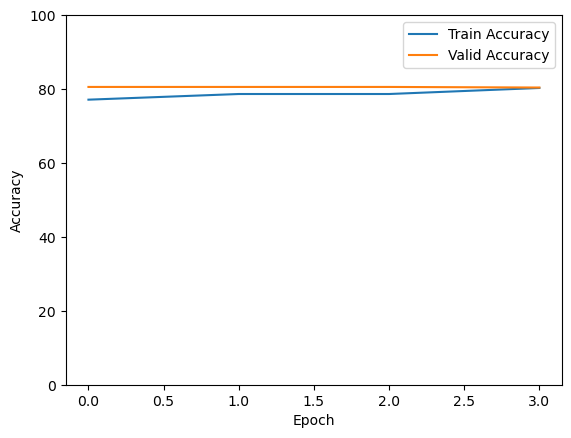

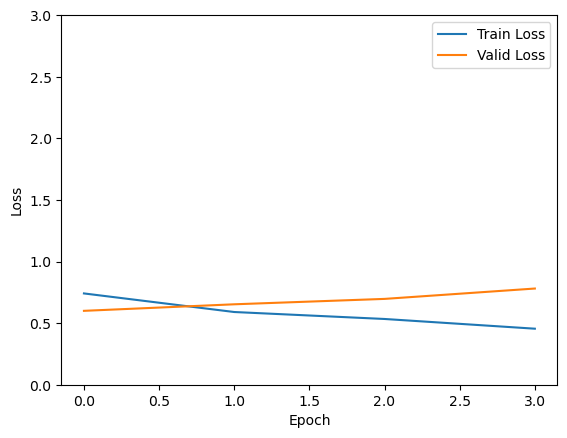

In [ ]:
# Plot train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()

# Plot train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend()
plt.show()

### Interpretations

The accuracy obtained is 80.23%! This is indicative of a good model as the accuracy is homegenuos with all the datasets of test, train and validation. The accuracy vs epoch and loss vs epoch graphs also look ideal. The model performs well on unseen data.

### Future Improvement

Other models can be tried to solve this problem and check if their accuracy dwells better than that of ResNet152 with the same of different parameters. Accuracy of CNN, RNN and hybrid models of CNN and RNN can be used to compare accuracies in the future.

### Demo of a sample Audio

Lets pass a sample murmur and try to know the classificaiton

In [ ]:
# Load audio file
audio_file = '/kaggle/input/heart-murmur-detection/heart_murmur_detection/training_data/9979_TV.wav'

# Preprocess audio and convert to spectrogram
spec = process_spec(preprocess_audio(audio_file))[np.newaxis, ...]

spec = spec.reshape(1, *spec.shape)  # add a new axis

# Wrap the numpy array in a PyTorch tensor and move it to the GPU if available
data = torch.tensor(spec, dtype=torch.float32)
if torch.cuda.is_available():
    data = data.cuda()

# Get prediction from ResNet model
resnet_model.eval()
with torch.no_grad():
    output = resnet_model(data)
prediction = output.argmax().item()

# Convert the prediction to the corresponding class label using the c2i dictionary
label = test_data.i2c[prediction]

print(f"Prediction: {label}")

Prediction: 0


### Interpretation 

The murmur was classified correctly.